# 6. Selección de Modelos

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Dataset

Definimos datos de *lenguaje natural* de juguete, y vectorizamos el input usando **bolsas de palabras**.

In [2]:
training = [
    ('chinese beijing chinese', 'zh'),
    ('chinese chinese shangai', 'zh'),
    ('chinese macao', 'zh'),
    ('chinese beijing tokyo', 'zh'),
    ('chinese beijing osaka', 'zh'),
    ('tokyo japan chinese', 'ja'),
    ('tokyo japan osaka', 'ja'),
    ('osaka', 'ja'),
]

In [3]:
# Documentos
X_docs = np.array([doc for doc, _ in training])

# Categorías
y = np.array([cls for _, cls in training])

In [4]:
from sklearn.feature_extraction.text import CountVectorizer

vect = CountVectorizer()

# Definición de Bag of Words
X = vect.fit_transform(X_docs)

# Dimensiones
X.shape

(8, 7)

## Validación Cruzada

- [Cross-validation: evaluating estimator performance](https://scikit-learn.org/stable/modules/cross_validation.html)

### División K-Fold

Podemos usar [K-Fold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html) para hacer *cross-validation*:

In [5]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=4, shuffle=True, random_state=0)

for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    print(f'TRAIN: {train_index} {y_train} VAL: {val_index} {y_val}')

TRAIN: [0 1 3 4 5 7] ['zh' 'zh' 'zh' 'zh' 'ja' 'ja'] VAL: [2 6] ['zh' 'ja']
TRAIN: [0 2 3 4 5 6] ['zh' 'zh' 'zh' 'zh' 'ja' 'ja'] VAL: [1 7] ['zh' 'ja']
TRAIN: [1 2 4 5 6 7] ['zh' 'zh' 'zh' 'ja' 'ja' 'ja'] VAL: [0 3] ['zh' 'zh']
TRAIN: [0 1 2 3 6 7] ['zh' 'zh' 'zh' 'zh' 'ja' 'ja'] VAL: [4 5] ['zh' 'ja']


Manualmente, sería posible entrenar (`model.fit(X_train, y_train)`) y predecir (`model.predict(X_val)`) en cada iteración.

### División K-Fold Estratificada

Para que la división sea estratificada, usamos [StratifiedKFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html):

In [6]:
from sklearn.model_selection import StratifiedKFold

kf = StratifiedKFold(n_splits=2, shuffle=True, random_state=0)

for train_index, val_index in kf.split(X, y):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    print(f'TRAIN: {train_index} {y_train} VAL: {val_index} {y_val}')

TRAIN: [3 4 6 7] ['zh' 'zh' 'ja' 'ja'] VAL: [0 1 2 5] ['zh' 'zh' 'zh' 'ja']
TRAIN: [0 1 2 5] ['zh' 'zh' 'zh' 'ja'] VAL: [3 4 6 7] ['zh' 'zh' 'ja' 'ja']


Manualmente, sería posible entrenar (`model.fit(X_train, y_train)`) y predecir (`model.predict(X_val)`) en cada iteración.

## Búsqueda en Grilla (Grid Search)

- [Tuning the hyper-parameters of an estimator](https://scikit-learn.org/stable/modules/grid_search.html)

### Grilla de Parámetros

In [7]:
from sklearn.tree import DecisionTreeClassifier

DecisionTreeClassifier??

In [8]:
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [1, 2],
}

Podemos listar todas las combinaciones para usarlas a mano con [ParameterGrid](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ParameterGrid.html):

In [9]:
from sklearn.model_selection import ParameterGrid

for params in ParameterGrid(param_grid):
    print(params)
    model = DecisionTreeClassifier(**params, random_state=0)
    # Se podría trabajar sobre el modelo construido.

{'criterion': 'gini', 'max_depth': 1}
{'criterion': 'gini', 'max_depth': 2}
{'criterion': 'entropy', 'max_depth': 1}
{'criterion': 'entropy', 'max_depth': 2}


Manualmente, sería posible entrenar (`model.fit(X_train, y_train)`) y predecir (`model.predict(X_val)`) en cada iteración.

### Grilla de Parámetros + Validación Cruzada

[GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) nos sirve para hacer **validación cruzada** sobre una **grilla de parámetros**. *Sklearn* se encarga de todo el proceso y nos devuelve una tabla de resultados y el mejor clasificador obtenido.

La búsqueda se puede configurar de varias maneras. Por defecto la validación cruzada es *estratificada*.

- [scoring parameter](https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter9)

In [10]:
from sklearn.model_selection import GridSearchCV

model = DecisionTreeClassifier(random_state=0)

cv = GridSearchCV(model, param_grid, scoring='accuracy', cv=3)
cv.fit(X, y);

In [11]:
# Obtenemos los resultados de la VC sobre la Grilla de Parámetros.
results = cv.cv_results_

# Parámetros
params = results['params']
# Media de la Puntuación
mean = results['mean_test_score']
# Desviación de la Puntuación
std = results['std_test_score']
# Ranking de Puntuaciones
rank = results['rank_test_score']

print('criterion \t depth \t | \t mean \t std \t rank')
for p, m, s, r in zip(params, mean, std, rank):
    c = p['criterion']
    d = p['max_depth']
    print(f'{c:8} \t {d} \t | \t {m:0.3f} \t {s:0.3f} \t {r}')

criterion 	 depth 	 | 	 mean 	 std 	 rank
gini     	 1 	 | 	 0.500 	 0.136 	 3
gini     	 2 	 | 	 0.611 	 0.079 	 1
entropy  	 1 	 | 	 0.500 	 0.136 	 3
entropy  	 2 	 | 	 0.611 	 0.079 	 1


In [12]:
import pandas as pd

cols = [
    'param_criterion',
    'param_max_depth',
    'mean_test_score',
    'std_test_score',
    'rank_test_score'
]

df = pd.DataFrame(results, columns=cols)

df

,param_criterion,param_max_depth,mean_test_score,std_test_score,rank_test_score
0,gini,1,0.500000,0.136083,3
1,gini,2,0.611111,0.078567,1
2,entropy,1,0.500000,0.136083,3
3,entropy,2,0.611111,0.078567,1


In [13]:
cv.best_params_

{'criterion': 'gini', 'max_depth': 2}

In [14]:
best_model = cv.best_estimator_

best_model.classes_

array(['ja', 'zh'], dtype='<U2')

In [15]:
best_model.predict(vect.transform(['chinese japan']))

array(['ja'], dtype='<U2')

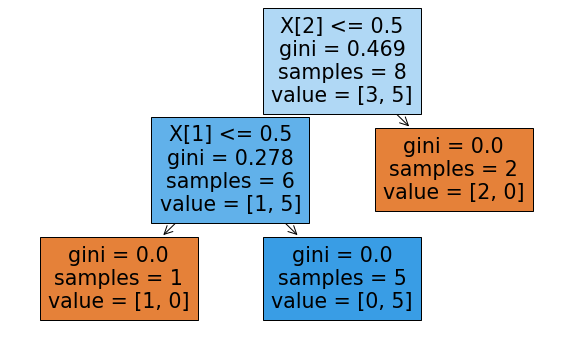

In [16]:
from sklearn.tree import plot_tree

fig = plt.figure(figsize=(10, 6))

plot_tree(best_model, filled=True);

In [17]:
vect.get_feature_names()

['beijing', 'chinese', 'japan', 'macao', 'osaka', 'shangai', 'tokyo']

### Búsqueda Aleatoria

- [Randomized Parameter Optimization](https://scikit-learn.org/stable/modules/grid_search.html#randomized-parameter-optimization)

In [18]:
from sklearn.linear_model import SGDClassifier

SGDClassifier??

In [19]:
from sklearn.utils.fixes import loguniform

param_dist = {
    'loss': [
        'hinge',      # SVM
        'log',        # logistic regression
        'perceptron', # perceptron
    ],
    'alpha': loguniform(0.0001, 100),
}

Podemos muestrear a mano con [ParameterSampler](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ParameterSampler.html):

In [20]:
from sklearn.model_selection import ParameterSampler

for params in ParameterSampler(param_dist, 10, random_state=0):
    print(params)
    model = SGDClassifier(**params, random_state=0)
    # Se podría trabajar sobre el modelo construido.

{'alpha': 0.196282248134428, 'loss': 'log'}
{'alpha': 11.630395714480306, 'loss': 'log'}
{'alpha': 0.5512926225087423, 'loss': 'perceptron'}
{'alpha': 0.042220489831498266, 'loss': 'perceptron'}
{'alpha': 0.0002189161813274828, 'loss': 'hinge'}
{'alpha': 0.01998246739232945, 'loss': 'perceptron'}
{'alpha': 7.46470024356059, 'loss': 'perceptron'}
{'alpha': 0.256016152500287, 'loss': 'log'}
{'alpha': 10.386580256500283, 'loss': 'hinge'}
{'alpha': 0.0003332543279005117, 'loss': 'hinge'}


Manualmente, sería posible entrenar (`model.fit(X_train, y_train)`) y predecir (`model.predict(X_val)`) en cada iteración.

### Búsqueda Aleatoria + Validación Cruzada

También podemos dejar que *sklearn* se encargue de todo con [RandomizedSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html):

In [21]:
from sklearn.model_selection import RandomizedSearchCV

model = SGDClassifier(random_state=0)

cv = RandomizedSearchCV(model, param_dist, n_iter=10, cv=3, random_state=0)
cv.fit(X, y);

In [22]:
import pandas as pd

# Obtenemos los resultados de la VC sobre la Búsqueda Aleatoria de Parámetros.
results = cv.cv_results_

cols = [
    'param_loss',
    'param_alpha',
    'mean_test_score',
    'std_test_score',
    'rank_test_score'
]

df = pd.DataFrame(results, columns=cols)

df

,param_loss,param_alpha,mean_test_score,std_test_score,rank_test_score
0,log,0.196282,0.888889,0.157135,4
1,log,11.630396,0.888889,0.157135,4
2,perceptron,0.551293,1.000000,0.000000,1
3,perceptron,0.04222,1.000000,0.000000,1
4,hinge,0.000219,0.888889,0.157135,4
5,perceptron,0.019982,1.000000,0.000000,1
6,perceptron,7.4647,0.722222,0.207870,10
7,log,0.256016,0.888889,0.157135,4
8,hinge,10.38658,0.888889,0.157135,4
9,hinge,0.000333,0.888889,0.157135,4


In [23]:
cv.best_params_

{'alpha': 0.5512926225087423, 'loss': 'perceptron'}

In [24]:
cv.best_estimator_

SGDClassifier(alpha=0.5512926225087423, loss='perceptron', random_state=0)

## Referencias

*Scikit-learn*:

- [Tuning the hyper-parameters of an estimator](https://scikit-learn.org/stable/modules/grid_search.html#grid-search)